 Dataset split (train/test) created in: /kaggle/working/Malimg_split_moco_tt
[train] total images: 4665
[test] total images: 4674
Classes: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], MoCo Loss: 5.0157
Epoch [2/100], MoCo Loss: 5.3875
Epoch [3/100], MoCo Loss: 5.4095
Epoch [4/100], MoCo Loss: 5.4300
Epoch [5/100], MoCo Loss: 5.3475
Epoch [6/100], MoCo Loss: 5.3201
Pretraining early-stopped at epoch 6. Best MoCo loss: 5.0157
MoCo pretraining finished. Saved backbone -> moco_Malimg_backbone.pth
Loaded MoCo backbone. Missing: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 2000x2000 with 0 Axes>

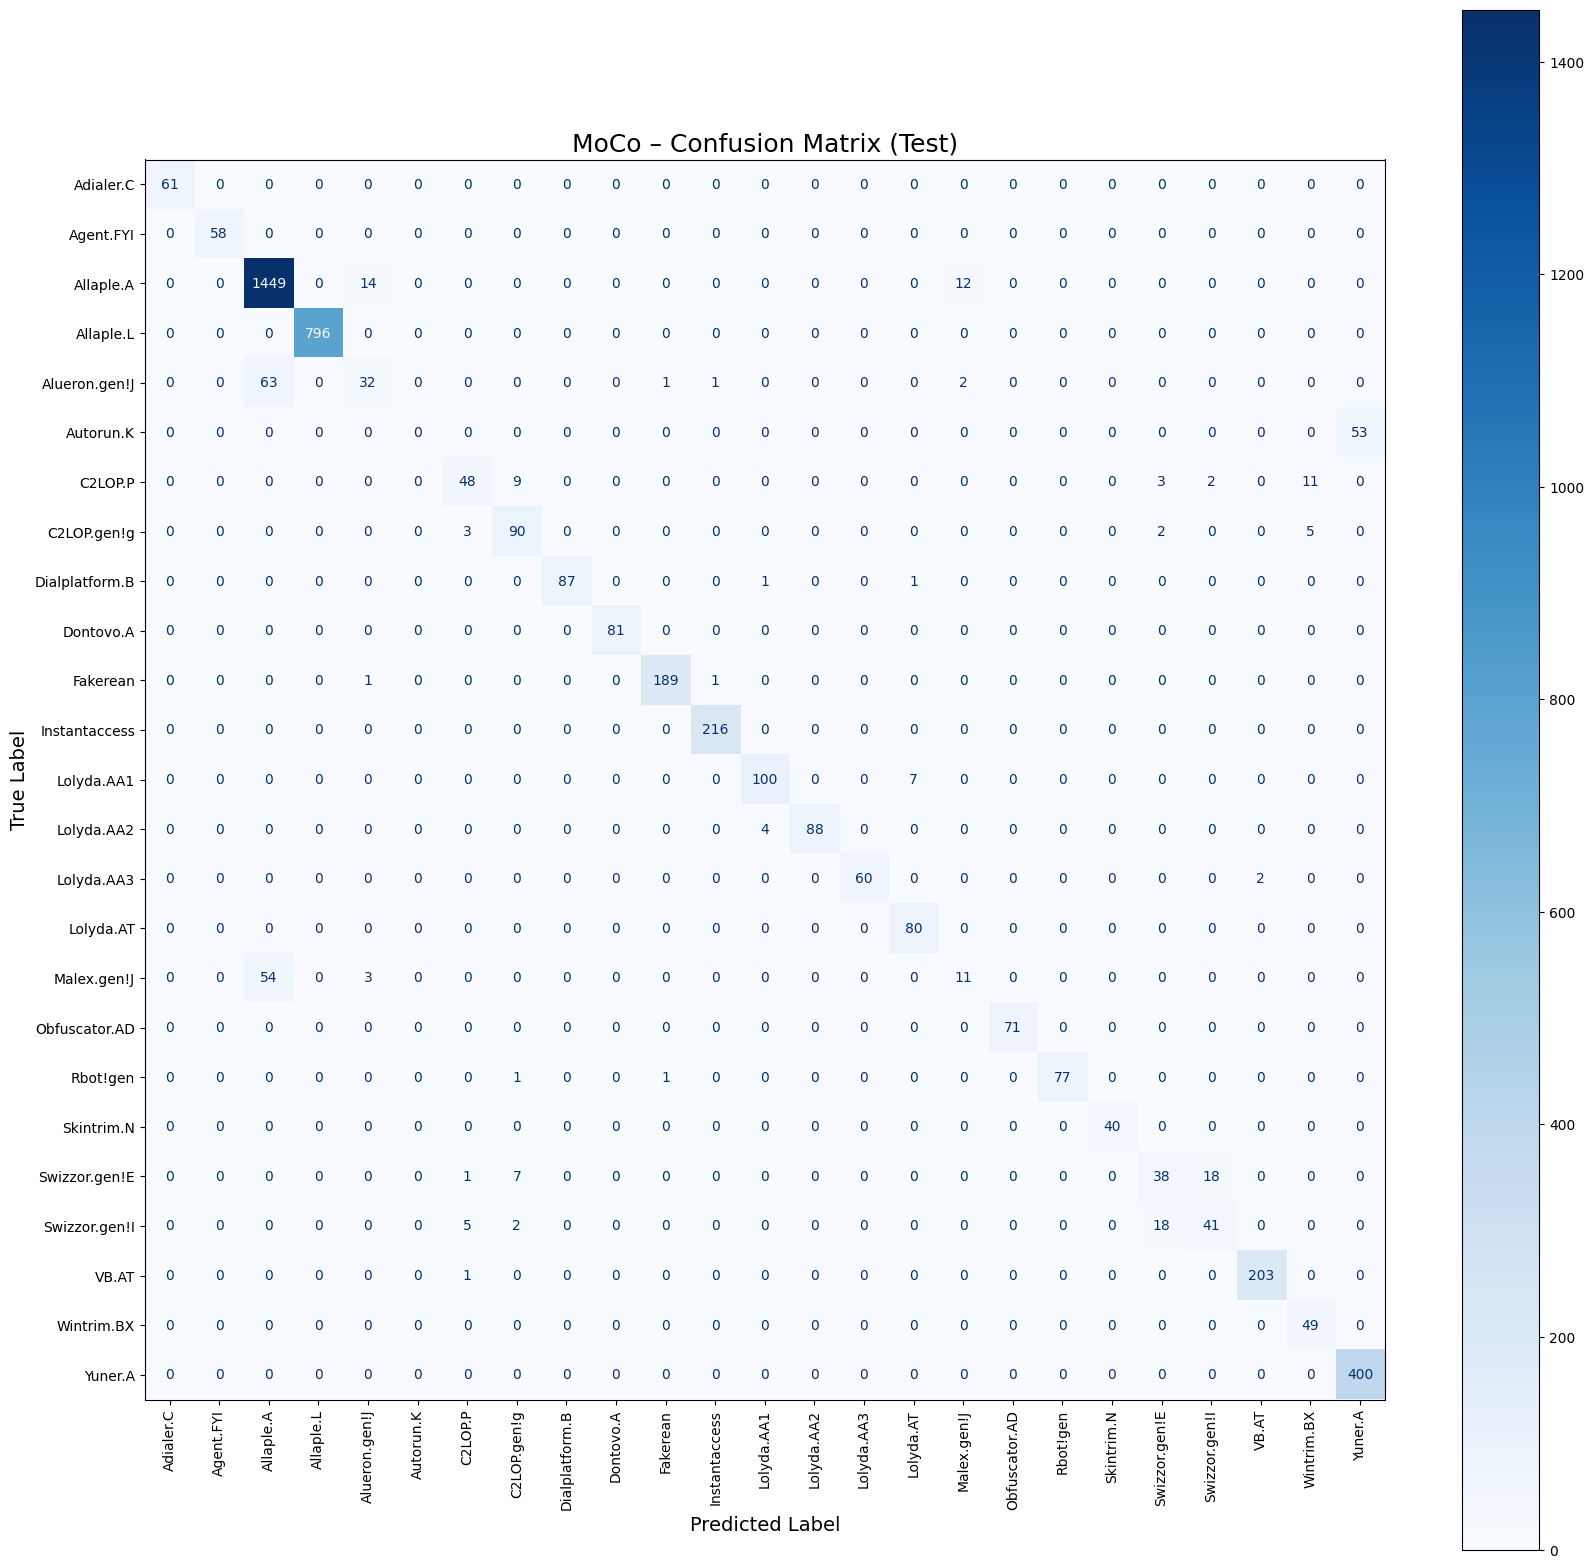

Class Adialer.C ROC-AUC: 1.0000
Class Agent.FYI ROC-AUC: 1.0000
Class Allaple.A ROC-AUC: 0.9940
Class Allaple.L ROC-AUC: 1.0000
Class Alueron.gen!J ROC-AUC: 0.9689
Class Autorun.K ROC-AUC: 0.9567
Class C2LOP.P ROC-AUC: 0.9959
Class C2LOP.gen!g ROC-AUC: 0.9981
Class Dialplatform.B ROC-AUC: 1.0000
Class Dontovo.A ROC-AUC: 1.0000
Class Fakerean ROC-AUC: 1.0000
Class Instantaccess ROC-AUC: 1.0000
Class Lolyda.AA1 ROC-AUC: 0.9994
Class Lolyda.AA2 ROC-AUC: 0.9989
Class Lolyda.AA3 ROC-AUC: 0.9806
Class Lolyda.AT ROC-AUC: 0.9998
Class Malex.gen!J ROC-AUC: 0.9437
Class Obfuscator.AD ROC-AUC: 1.0000
Class Rbot!gen ROC-AUC: 1.0000
Class Skintrim.N ROC-AUC: 1.0000
Class Swizzor.gen!E ROC-AUC: 0.9935
Class Swizzor.gen!I ROC-AUC: 0.9890
Class VB.AT ROC-AUC: 0.9984
Class Wintrim.BX ROC-AUC: 0.9999
Class Yuner.A ROC-AUC: 0.9938
Macro-average ROC-AUC: 0.9924


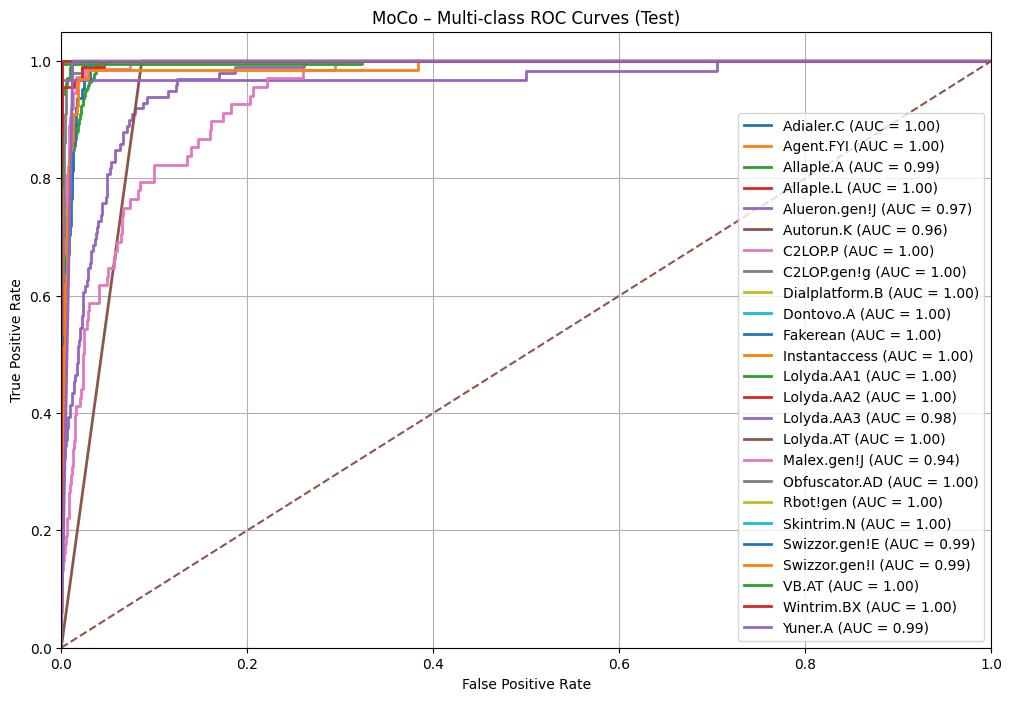

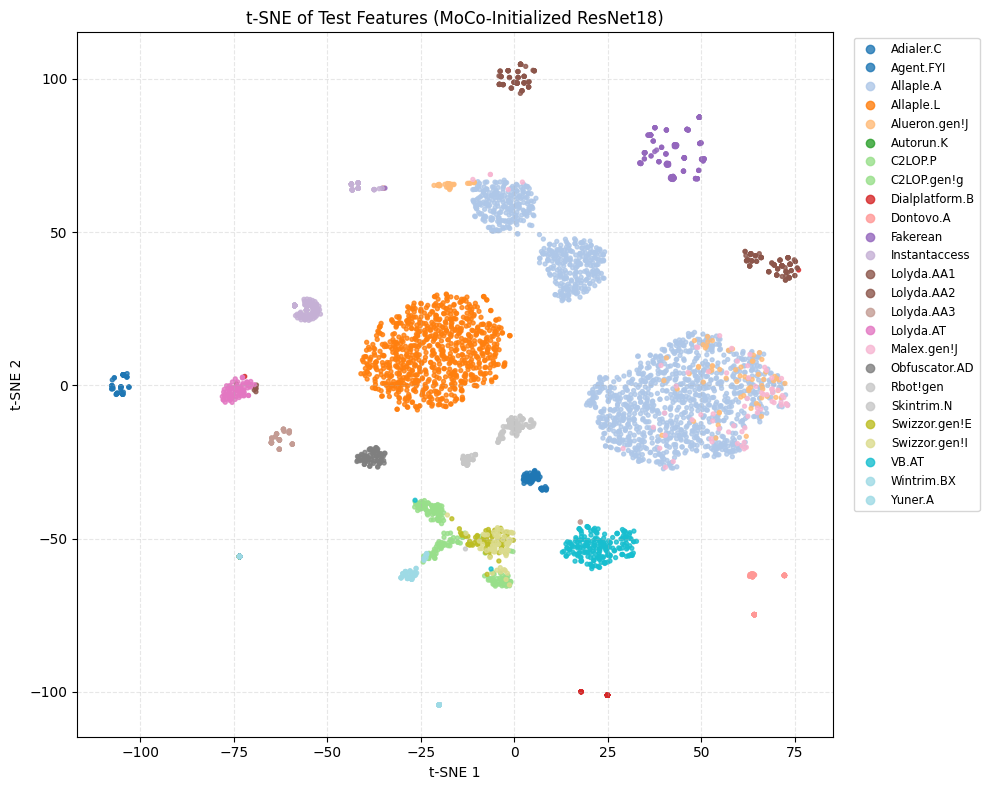

In [1]:
# ============================================
# MoCo (v2-style) Training + Eval on Malimg
# (Train/Test only + Early Stopping + Classif. Report + Avg Inference Time)
# + WeightedRandomSampler for class imbalance
# ============================================

import os
import random
import shutil
import time
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Repro / Device
# -----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# -----------------------------
# 1) Paths & Split (flat class dirs) — TRAIN/TEST ONLY
# -----------------------------
import os, shutil, random
from glob import glob

random.seed(42)

root_dir = "/kaggle/input/malimg"
working_dir = "/kaggle/working/Malimg_split_moco_tt"   # new working dir for train/test only

# Adjust the ratio as you like (default 80/20)
train_ratio, test_ratio = 0.5, 0.5
splits = ["train", "test"]
IMAGE_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

os.makedirs(working_dir, exist_ok=True)
for s in splits:
    os.makedirs(os.path.join(working_dir, s), exist_ok=True)

# Only build the split if it's empty (prevents duplicate copies)
needs_split = any(len(os.listdir(os.path.join(working_dir, s))) == 0 for s in splits)

if needs_split:
    for cls in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        # Images directly under each class folder
        images = [os.path.join(class_dir, f)
                  for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f))
                  and f.lower().endswith(IMAGE_EXTS)]

        # Optional fallback: if your dataset has a stray subfolder level
        if len(images) == 0:
            images = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True)
                      if os.path.isfile(p) and p.lower().endswith(IMAGE_EXTS)]

        if len(images) == 0:
            continue  # no files for this class

        random.shuffle(images)
        n = len(images)
        n_train = int(n * train_ratio)

        assigns = {
            "train": images[:n_train],
            "test":  images[n_train:]
        }

        for s in splits:
            dest_dir = os.path.join(working_dir, s, cls)
            os.makedirs(dest_dir, exist_ok=True)
            for src in assigns[s]:
                try:
                    shutil.copy2(src, dest_dir)  # copy from read-only /kaggle/input
                except Exception:
                    pass  # skip unreadable/problem files

    print(" Dataset split (train/test) created in:", working_dir)
else:
    print(" Using existing train/test split in:", working_dir)

# Quick sanity check
for s in splits:
    total = 0
    split_root = os.path.join(working_dir, s)
    for cls in os.listdir(split_root):
        cdir = os.path.join(split_root, cls)
        if os.path.isdir(cdir):
            total += sum(os.path.isfile(os.path.join(cdir, f)) for f in os.listdir(cdir))
    print(f"[{s}] total images: {total}")

# -----------------------------
# 2) Transforms 
# -----------------------------
# Strong augments for self-supervised pretraining
pretrain_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert grayscale → RGB
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# Light augments for classifier fine-tuning/eval
clf_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert grayscale → RGB
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# -----------------------------
# 3) Two-views dataset for MoCo
# -----------------------------
from PIL import Image

class ImageFolderTwoViews(ImageFolder):
    """Returns (view1, view2), label from a single image path using the same base transform twice."""
    def __init__(self, root, base_transform):
        super().__init__(root, transform=None)
        self.base_transform = base_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if isinstance(img, Image.Image) is False:
            img = Image.open(path).convert("RGB")
        im1 = self.base_transform(img)
        im2 = self.base_transform(img)
        return (im1, im2), target

# -----------------------------
# 4) Datasets & Loaders (NO VAL) + WEIGHTED SAMPLERS
# -----------------------------
batch_size = 128
num_workers = 4 if device == "cuda" else 2
pin_memory = device == "cuda"

# Pretraining dataset: train split with two views
pretrain_dataset = ImageFolderTwoViews(os.path.join(working_dir, "train"), base_transform=pretrain_transform)

# Supervised datasets
train_dataset = ImageFolder(os.path.join(working_dir, "train"), transform=clf_transform)
test_dataset  = ImageFolder(os.path.join(working_dir, "test"),  transform=clf_transform)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

# ---- Build sample weights for imbalance (train split) ----
# ImageFolder provides .targets (list of class indices per sample)
train_targets = np.array(train_dataset.targets)
class_counts  = np.bincount(train_targets, minlength=num_classes).astype(np.float64)
class_weights = 1.0 / np.maximum(class_counts, 1.0)         # inverse frequency
sample_weights_train = class_weights[train_targets]          # per-sample weights

# Same for the two-views pretraining dataset
pretrain_targets = np.array(pretrain_dataset.targets)
sample_weights_pretrain = class_weights[pretrain_targets]

# Weighted samplers (replacement=True recommended)
train_sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights_train, dtype=torch.double),
    num_samples=len(sample_weights_train),
    replacement=True
)
pretrain_sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights_pretrain, dtype=torch.double),
    num_samples=len(sample_weights_pretrain),
    replacement=True
)

# DataLoaders (when using sampler, set shuffle=False)
pretrain_loader = DataLoader(
    pretrain_dataset, batch_size=batch_size, sampler=pretrain_sampler,
    shuffle=False, drop_last=True, num_workers=num_workers, pin_memory=pin_memory
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler,
    shuffle=False, drop_last=True, num_workers=num_workers, pin_memory=pin_memory
)
test_loader  = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory
)

# -----------------------------
# 5) MoCo (v2-style) Model
# -----------------------------
class ResNetBackbone(nn.Module):
    """ResNet18 backbone that returns a 512-d feature vector (fc replaced by Identity)."""
    def __init__(self):
        super().__init__()
        m = resnet18(pretrained=False)
        m.fc = nn.Identity()
        self.encoder = m

    def forward(self, x):
        return self.encoder(x)  # (N, 512)

class MLPHead(nn.Module):
    """MoCo v2 projection head: 512 -> 2048 -> 128"""
    def __init__(self, in_dim=512, hidden=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class MoCo(nn.Module):
    """
    Minimal single-GPU MoCo v2:
      - momentum encoder (key) updated by EMA
      - queue of negative keys
      - InfoNCE loss (CE with temperature)
    """
    def __init__(self, feature_dim=128, K=16384, m=0.99, T=0.07):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T

        # Encoders (output 512-d features)
        self.encoder_q = ResNetBackbone()
        self.encoder_k = ResNetBackbone()

        # Projection heads to 128-d
        self.mlp_q = MLPHead(in_dim=512, hidden=2048, out_dim=feature_dim)
        self.mlp_k = MLPHead(in_dim=512, hidden=2048, out_dim=feature_dim)

        # Copy params from q -> k
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data.copy_(p_q.data)
            p_k.requires_grad = False
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data.copy_(p_q.data)
            p_k.requires_grad = False

        # Create the queue
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """EMA update for key encoder and its MLP head."""
        for p_q, p_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)
        for p_q, p_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            p_k.data = p_k.data * self.m + p_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """keys: (N, C) already L2-normalized"""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        end = ptr + batch_size
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first_len = self.K - ptr
            self.queue[:, ptr:] = keys[:first_len].T
            self.queue[:, :end - self.K] = keys[first_len:].T

        self.queue_ptr[0] = (end) % self.K

    def forward(self, im_q, im_k):
        """
        im_q, im_k: (N, C, H, W)
        Returns CE logits and labels=0 (pos at idx 0).
        """
        # Query branch
        q_feat = self.encoder_q(im_q)                # (N, 512)
        q = self.mlp_q(q_feat)                       # (N, 128)
        q = nn.functional.normalize(q, dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k_feat = self.encoder_k(im_k)            # (N, 512)
            k = self.mlp_k(k_feat)                   # (N, 128)
            k = nn.functional.normalize(k, dim=1)

        # Positive logits: q · k
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)  # (N,1)

        # Negative logits: q · queue
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])  # (N,K)

        # Logits: [pos | neg]
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update queue
        with torch.no_grad():
            self._dequeue_and_enqueue(k)

        return logits, labels

# -----------------------------
# 6) Pretrain MoCo on train split  (NOW WITH EARLY STOPPING)
# -----------------------------
moco = MoCo(feature_dim=128, K=16384, m=0.99, T=0.07).to(device)
optimizer = optim.Adam(moco.parameters(), lr=1e-3)
epochs_ssl = 100

# ---- Early stopping (pretraining) ----
ssl_patience = 5
best_ssl_loss = float("inf")
ssl_no_improve = 0

moco.train()
for epoch in range(epochs_ssl):
    total_loss = 0.0
    for (im1, im2), _ in pretrain_loader:
        im_q = im1.to(device, non_blocking=True)
        im_k = im2.to(device, non_blocking=True)

        logits, labels = moco(im_q, im_k)
        loss = nn.CrossEntropyLoss()(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss/len(pretrain_loader)
    print(f"Epoch [{epoch+1}/{epochs_ssl}], MoCo Loss: {epoch_loss:.4f}")

    # early stopping check on epoch loss
    if epoch_loss + 1e-6 < best_ssl_loss:
        best_ssl_loss = epoch_loss
        ssl_no_improve = 0
        best_ssl_state = {k: v.cpu().clone() for k, v in moco.encoder_q.state_dict().items()}
    else:
        ssl_no_improve += 1
        if ssl_no_improve >= ssl_patience:
            print(f"Pretraining early-stopped at epoch {epoch+1}. Best MoCo loss: {best_ssl_loss:.4f}")
            break

# If we captured a best state, load it back before saving
if 'best_ssl_state' in locals():
    moco.encoder_q.load_state_dict(best_ssl_state)

# Save ONLY the backbone (encoder_q)
torch.save(moco.encoder_q.state_dict(), "moco_Malimg.pth")
print("MoCo pretraining finished. Saved backbone -> moco_Malimg_backbone.pth")

# -----------------------------
# 7) Linear/classifier fine-tuning (NO VAL) + EARLY STOPPING (train loss)
# -----------------------------
# Build a fresh backbone and load MoCo weights
backbone = resnet18(pretrained=False)
backbone.fc = nn.Identity()
missing, unexpected = backbone.load_state_dict(moco.encoder_q.state_dict(), strict=False)
print("Loaded MoCo backbone. Missing:", missing, "| Unexpected:", unexpected)
backbone = backbone.to(device)

# Unfreeze only layer4
for name, p in backbone.named_parameters():
    p.requires_grad = ("layer4" in name)

classifier = nn.Linear(512, num_classes).to(device)

params_to_opt = list(classifier.parameters()) + [p for p in backbone.parameters() if p.requires_grad]
optimizer_cls = optim.Adam(params_to_opt, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_cls, step_size=10, gamma=0.5)

criterion = nn.CrossEntropyLoss()
epochs_cls = 100

# Early stopping on training loss (since no validation)
patience = 5
best_train_loss = float("inf")
epochs_no_improve = 0
best_states = None

for epoch in range(epochs_cls):
    backbone.train()
    classifier.train()
    total_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        feats = backbone(images)          # (N, 512)
        logits = classifier(feats)        # (N, C)
        loss = criterion(logits, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs_cls}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Early stopping check (train loss)
    if train_loss + 1e-6 < best_train_loss:
        best_train_loss = train_loss
        epochs_no_improve = 0
        best_states = {
            "backbone": backbone.state_dict(),
            "classifier": classifier.state_dict()
        }
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Train Loss: {best_train_loss:.4f}")
            break

    scheduler.step()

# -----------------------------
# Save best model
# -----------------------------
if best_states is not None:
    torch.save(best_states, "moco_finetuned_best.pth")
    print("Best model (by train loss) saved to moco_finetuned_best.pth")

# -----------------------------
# 8) Test evaluation (+ Classification Report + Avg Inference Time)
# -----------------------------
# Load best states before testing
if best_states is not None:
    backbone.load_state_dict(best_states["backbone"])
    classifier.load_state_dict(best_states["classifier"])
backbone.eval()
classifier.eval()

t_correct = 0
all_preds, all_labels = [], []
all_probs = []

# Measure average per-image inference time over the test set
n_images = 0
infer_time_total = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        start_batch = time.perf_counter()

        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        feats = backbone(images)
        logits = classifier(feats)

        end_batch = time.perf_counter()
        infer_time_total += (end_batch - start_batch)
        n_images += images.size(0)

        probs = torch.softmax(logits, dim=1)

        t_correct += (logits.argmax(1) == labels).sum().item()
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_acc = t_correct / len(test_dataset)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
avg_infer_time_per_image = infer_time_total / max(1, n_images)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Average Inference Time per Image: {avg_infer_time_per_image*1000:.3f} ms")

# Classification report
print("Classification Report:")
print(classification_report(all_labels, np.array(all_preds), target_names=test_dataset.classes, digits=4))

# -----------------------------
# 9) Confusion Matrix (Bigger & Clearer)
# -----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)

disp.plot(cmap=plt.cm.Blues,
          xticks_rotation=90,    # rotate x-axis labels fully
          values_format='d')

plt.title("MoCo – Confusion Matrix (Test)", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.gcf().set_size_inches(20, 20)  # double ensure bigger size
plt.show()

# -----------------------------
# 10) ROC-AUC (per-class + macro) and ROC Curves
# -----------------------------
num_classes = len(test_dataset.classes)
labels_onehot = label_binarize(all_labels, classes=np.arange(num_classes))

# Per-class ROC-AUC
roc_auc_per_class = roc_auc_score(labels_onehot, all_probs, average=None)
for i, cls in enumerate(test_dataset.classes):
    print(f"Class {cls} ROC-AUC: {roc_auc_per_class[i]:.4f}")
print(f"Macro-average ROC-AUC: {roc_auc_score(labels_onehot, all_probs, average='macro'):.4f}")

# ROC Curves
plt.figure(figsize=(12, 8))
for i, cls in enumerate(test_dataset.classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MoCo – Multi-class ROC Curves (Test)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -----------------------------
# 11) t-SNE Visualization of Learned Features (NEW)
# -----------------------------
from sklearn.manifold import TSNE

# extract features for test set
backbone.eval()
features_list, labels_list = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        feats = backbone(images)              # (N, 512)
        features_list.append(feats.cpu().numpy())
        labels_list.extend(labels.numpy())

features = np.concatenate(features_list, axis=0)
labels_arr = np.array(labels_list)

# run t-SNE on 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, init="pca")
emb = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb[:, 0], emb[:, 1], c=labels_arr, s=8, alpha=0.8, cmap="tab20")
handles, _ = scatter.legend_elements(num=len(test_dataset.classes))
plt.legend(handles, test_dataset.classes, bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
plt.title("t-SNE of Test Features (MoCo-Initialized ResNet18)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.show()
